In [1]:
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
from collections import Counter
from typing import Generator

# Подготовка данных

## Опреределние используемых функций

In [2]:
def load_file(path) -> pd.DataFrame:
    """Загружает данные из exel файла, удаляет незаполненные значения, формирует колонку временной метки"""
    
    df = pd.read_excel(path, header=0)
    df['DateTime']= pd.to_datetime(df['Date'].astype(str)+' '+ df['Time'].astype(str))
    df = df.drop(['Date', 'Time'], axis=1)
    df.replace('-',np.NaN, inplace=True)
    df.dropna(axis=0, how='any', inplace=True)
    return df


def plot_timedelta_distr(df: pd.DataFrame, name=None) -> None:
    """Рисует гистограмму распределения временными промежутками между соседними измерениями"""
    
    delta_arr = []
    for i in range(1, len(df)):
        delta_arr.append(df.iloc[i, -1] - df.iloc[i-1, -1])
    print(Counter(delta_arr), '\n')
    hist_arr = [i.total_seconds()/60 for i in delta_arr]
    plt.hist(hist_arr,)
    plt.xlabel("Величина промежутка между измерениями, мин")
    plt.ylabel("Количество промежутков")
    if name is not None:
        plt.title(name)
    plt.show()


def construct_XY(df_X: pd.DataFrame, df_Y: pd.DataFrame, max_diff: pd.Timedelta, diff2: pd.Timedelta) -> Generator[np.ndarray, np.ndarray, pd.Timestamp]:
    """Формирует генератор точек X и Y, каждому Y соответствует несколько X во временном промежутке"""
    
    num = 0
    Y = df_Y.iloc[num,:-1].to_numpy()
    X = np.array([],).reshape(0, len(df_X.columns)-1)
    for i in range(len(df_X)):
        timeX = df_X.iloc[i, -1]
        timeY = df_Y.iloc[num, -1]
        if timeX > timeY:
            if timeX - timeY < diff2:
                tmp_X = df_X.iloc[i, :-1].to_numpy()
                X = np.vstack((X, tmp_X))
            yield X, Y, timeY
            num += 1            
            if num >= len(df_Y):
                break
            
            X = np.array([],).reshape(0, len(df_X.columns)-1)
            Y = df_Y.iloc[num,:-1].to_numpy()
            continue
        if timeY - timeX > max_diff:
            continue
        tmp_X = df_X.iloc[i, :-1].to_numpy()
        X = np.vstack((X, tmp_X))


def plot_num_distr(gen, name=None) -> None:
    """Рисует гистограмму распрделения количества точек X на одну точку Y"""
    
    shapes = []
    i = 0
    for x, y, _ in gen:
        i += 1
        shapes.append(len(x))
    print(f"Количество точек {i} \n")
    print(f'Распределение количества примеров \n {Counter(shapes)} \n')
    plt.hist(shapes)
    plt.xlabel("Количетсво точек X на одно лабораторное измерение")
    plt.ylabel("Количество записей")
    if name is not None:
        plt.title(name)
    plt.plot()

## Загрузка файлов

In [3]:
df_Y1 = load_file('Исходные данные/Лабораторные анализы Давление насыщенных паров в продукте, зимний период.xlsx')
df_Y2 = load_file('Исходные данные/Лабораторные анализы Конец кипения легкого бензина.xlsx')
df_Y3 = load_file('Исходные данные/Лабораторные анализы Содержание олефинов в продукте.xlsx')

df_X1 = load_file('Исходные данные/Процессные данные Давление насыщенных паров в продукте, зимний период.xlsx')
df_X2 = load_file('Исходные данные/Процессные данные Конец кипения легкого бензина.xlsx')
df_X3 = load_file('Исходные данные/Процессные данные Содержание олефинов в продукте.xlsx')

В загруженных файлах заменены пропуски, которые в таблице обозначены "-" на NaN значения, эти строки отброшены.

In [4]:
df_Y1

,"Давление насыщенных паров, зимний период, кПа",DateTime
0,49.8,2022-01-01 11:21:00
1,52.3,2022-01-02 10:50:00
2,50.7,2022-01-03 10:24:48
3,52.6,2022-01-04 11:12:49
4,54.7,2022-01-05 10:23:28
...,...,...
291,59.3,2023-12-05 11:30:47
292,57.4,2023-12-07 10:21:11
307,56.9,2024-01-30 11:27:17
308,60.7,2024-02-01 11:17:48


In [5]:
df_X1

,Расход бензина ККР на установку,Расход нафты ККР на установку,Расход бензина на рециркуляцию от Е-1205,Температура бензина ККР на установку,Давление в емкости V-1101,Расход сырья после Р-1101,Показатель соотношения водород к углероду,Расход водорода на смешение перед Е-1101,Температура сырья перед Е-1101,Давление сырья перед Е-1101,...,Давление продукта после Е-1205,Давление продукта на выходе с установки,Расход продукта на выходе с установки,Уровень V-1203,Температура V-1203,Давление V-1203,Температура верха С-1201,Давление верха С-1201,Давление С-1201,DateTime
0,95.63,32.56,0.00,29.94,1.21,146.96,5.31,781.16,32.40,29.13,...,3.40,0.24,106.00,44.99,20.56,14.95,25.55,14.74,14.88,2022-01-01 00:00:00
1,95.98,32.80,0.00,29.66,1.20,147.27,5.30,779.64,32.12,29.13,...,3.40,0.23,105.53,45.10,20.37,14.95,25.33,14.73,14.88,2022-01-01 01:25:00
2,95.60,32.76,0.00,29.84,1.20,146.05,5.34,780.48,32.29,29.12,...,3.40,0.24,105.52,45.20,20.52,14.95,25.49,14.74,14.88,2022-01-01 02:50:00
3,95.72,32.76,0.00,29.80,1.20,146.19,5.34,780.53,32.30,29.13,...,3.40,0.24,105.62,44.69,20.70,14.95,25.75,14.73,14.88,2022-01-01 04:15:00
4,95.53,32.80,0.00,29.83,1.20,145.76,5.32,776.46,32.25,29.12,...,3.40,0.24,105.62,44.98,20.58,14.95,25.59,14.74,14.88,2022-01-01 05:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12884,103.80,0.00,3.93,35.60,1.20,143.04,5.53,789.95,37.93,29.07,...,4.00,0.29,102.00,49.99,21.85,14.95,27.30,14.76,14.89,2024-02-06 20:00:00
12885,103.66,0.00,1.28,35.85,1.20,142.90,5.52,789.97,37.95,29.07,...,4.00,0.29,102.08,50.01,20.91,14.96,26.55,14.76,14.89,2024-02-06 21:00:00
12886,103.14,0.00,0.20,35.53,1.20,143.09,5.53,789.97,38.06,29.07,...,4.00,0.28,102.00,50.00,20.23,14.96,26.01,14.76,14.89,2024-02-06 22:00:00
12887,103.68,0.00,1.28,35.54,1.20,143.59,5.50,790.03,37.81,29.07,...,4.00,0.27,102.59,49.99,19.43,14.96,25.29,14.76,14.89,2024-02-06 23:00:00


## Анализ данных

Посмотрим, какая регулярность измерений процессорных данных. Для этого построим гистограмму распределения временного промежутка (в минутах) между двумя соседними измерениями.
Лабораторные анализы проиводились крайне нерегулярно, для них такая диаграмма не имеет смысла.

Counter({Timedelta('0 days 01:27:55'): 5992, Timedelta('0 days 01:25:00'): 1998, Timedelta('0 days 01:29:20'): 1998, Timedelta('0 days 01:27:50'): 1996, Timedelta('0 days 01:00:00'): 888, Timedelta('0 days 00:11:15'): 4, Timedelta('0 days 00:45:00'): 2, Timedelta('0 days 02:27:50'): 2, Timedelta('0 days 00:34:30'): 2, Timedelta('0 days 00:36:00'): 2, Timedelta('0 days 00:27:55'): 2, Timedelta('0 days 01:11:15'): 2}) 



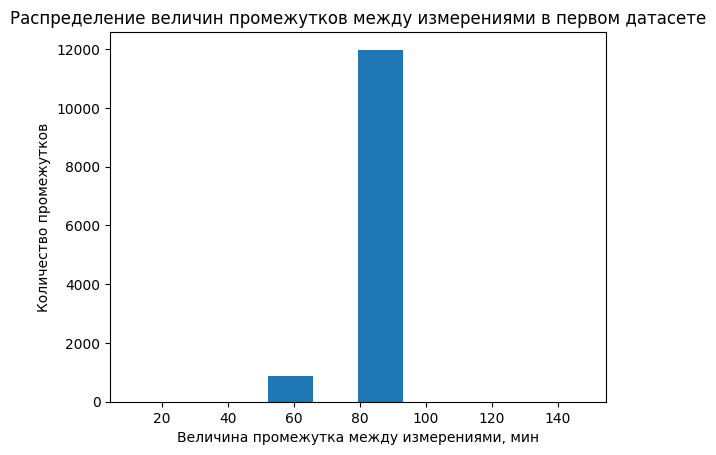

In [6]:
plot_timedelta_distr(df_X1, "Распределение величин промежутков между измерениями в первом датасете")

Как мы видим, даже процессорные измерения были не полностью регулярные, что может сказаться на количестве процессорных значений, соответствующих одному лабораторному анализу

Пройдёмся по нашим процессорным данным и поставим в соответствие лабораторным измерениям те процессорные данные, которые были получены не дальше чем diff времени до лабораторного анализа или diff2 времени после лабораторного анализа

In [7]:
diff = pd.to_timedelta('4h')
diff2 = pd.to_timedelta('15min')

Количество точек 134 

Распределение количества примеров 
 Counter({3: 122, 2: 4, 0: 3, 1: 2, 4: 2, 5: 1}) 



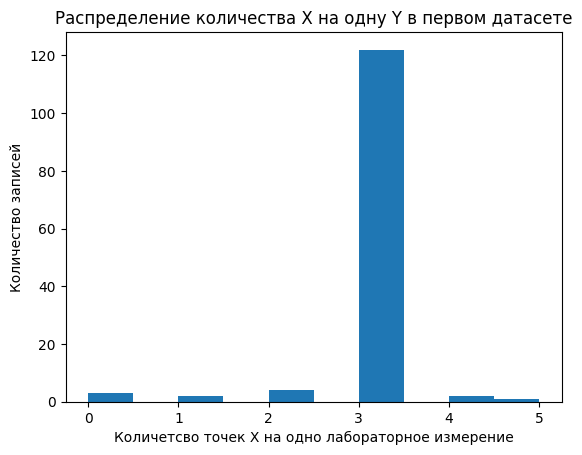

In [8]:
plot_num_distr(construct_XY(df_X1, df_Y1, diff, diff2), "Распределение количества X на одну Y в первом датасете")

Количество точек 110 

Распределение количества примеров 
 Counter({3: 93, 2: 12, 4: 4, 5: 1}) 



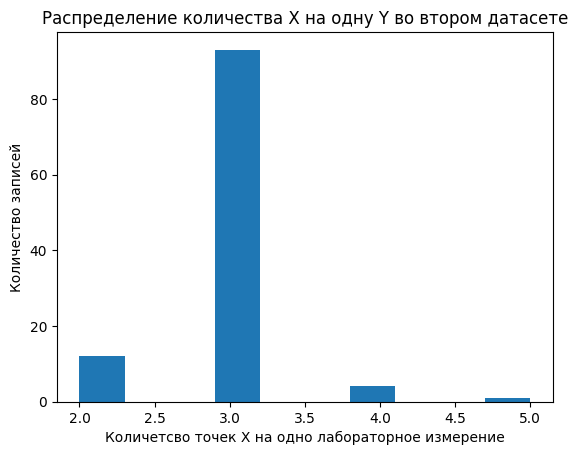

In [9]:
plot_num_distr(construct_XY(df_X2, df_Y2, diff, diff2), "Распределение количества X на одну Y во втором датасете")

Количество точек 226 

Распределение количества примеров 
 Counter({3: 195, 2: 20, 4: 9, 5: 2}) 



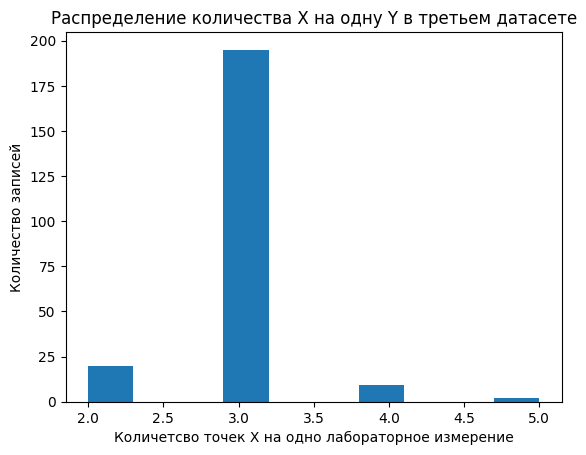

In [10]:
plot_num_distr(construct_XY(df_X3, df_Y3, diff, diff2), "Распределение количества X на одну Y в третьем датасете")

Как мы видим, при данных временных рамках одному лабораторному анализу может соответствовать от нуля до пяти процессорных данных. Чтобы иметь возможность адекватно обрабатывать данные, необходимо отбросить точки без процессорных данных и свести процессорные данные к единому формату. 
Подобная обработка процессорных данных может быть проделана, используя среднее или экпоенециальное среднее

## Формирование тестовой и обучающей выборки

## Описание функций

Функция формирования тестовой и обучающей выборки в numpy массивов, значения Х в каждой точке агрегируются в вектор. На вход подаётся свежий экземпляр генератора точек X и Y и функция агрегирования

In [11]:
def form_datasets(gen, agregate_func) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Формирует 4 numpy.ndarry в порядке x_test, y_test, x_train, y_train, значения Х получены через функцию агрегирования agregate_func"""
    
    x_train = None
    x_test = None
    y_train = None
    y_test = None

    while y_train is None:
        x, y, timestamp = next(gen)
        if len(x) == 0:
            continue
            
        y_train = np.array([],).reshape(0, len(y))
        y_test = np.array([],).reshape(0, len(y))
        x_train = np.array([],).reshape(0, x.shape[1])
        x_test = np.array([],).reshape(0, x.shape[1])

        breakpoint()
        x_agg = agregate_func(x)

        if timestamp.month in [1, 2, 12]:
            y_test = np.vstack((y_test, y))
            x_test = np.vstack((x_test, x_agg))
        else:
            y_train = np.vstack((y_train, y))
            x_train = np.vstack((x_train, x_agg))

    for x, y, timestamp in gen:
        
        if len(x) == 0:
            continue
            
        x_agg = agregate_func(x)

        if timestamp.month in [1, 2, 12]:
            y_test = np.vstack((y_test, y))
            x_test = np.vstack((x_test, x_agg))
        else:
            y_train = np.vstack((y_train, y))
            x_train = np.vstack((x_train, x_agg))

    return x_test, y_test, x_train, y_train

Функция агрегирования, обобщающая использование арифметического среднего, последнего значения и взвешенного экпоненциального среднего

In [12]:
def exp_average(arr: np.ndarray, alpha=0) -> np.ndarray:
    """Функция взвешенного среднего для агрегирования значений X. При alpha = 0 результат - арифметическое среднее, 
    при alpha = 1 результат - последнее значение, при alpha = (0, 1) результат - экспоненциальное взвешенное среднее"""

    arr = arr[::-1]
    out_arr = np.zeros(arr.shape[1])
    coeff_sum = 0
    for pow, row in enumerate(arr):
        coeff = (1-alpha)**pow
        out_arr = out_arr + row*coeff
        coeff_sum += coeff
    
    out_arr = out_arr/coeff_sum
    return out_arr

Сохранение данных в .npz архив

In [13]:
def save_datasets(gen1, gen2, gen3, func, func_name) -> None:
    """Генерирует и сохраняет датасеты с определённой функцией агрегирования func в .npz архив под именем Data_func_name.npz"""
    
    X_test_1, Y_test_1, X_train_1, Y_train_1 = form_datasets(gen1, func)
    X_test_2, Y_test_2, X_train_2, Y_train_2 = form_datasets(gen2, func)
    X_test_3, Y_test_3, X_train_3, Y_train_3 = form_datasets(gen3, func)
    
    np.savez_compressed(
        "Data_" + func_name +".npz", 
        X_test_1=X_test_1, Y_test_1=Y_test_1, X_train_1=X_train_1, Y_train_1=Y_train_1,
        X_test_2=X_test_2, Y_test_2=Y_test_2, X_train_2=X_train_2, Y_train_2=Y_train_2,
        X_test_3=X_test_3, Y_test_3=Y_test_3, X_train_3=X_train_3, Y_train_3=Y_train_3
    )
                       

## Сохранение размеченных данных

Сохраним архивы с 3 вариантами агрегирования (арифметическое среднее, последнее измерение, взвешенное экспоненциальное среднее. 

В каждом архиве находятся по 4 массива для 3 виртуальных анализаторов. Номер ВА - последняя цифра в названии массива (1 - Давление насыщенных паров в продукте, зимний период, 2 - Конец кипения легкого бензина, 3 - Содержание олефинов в продукте). 

Каждый массив построен по следующему принципу Y[N], X[N, C], где N - номер точки, C - номер процессорного значения.

In [14]:
a = 0
save_datasets(
    construct_XY(df_X1, df_Y1, diff, diff2),
    construct_XY(df_X2, df_Y2, diff, diff2),
    construct_XY(df_X3, df_Y3, diff, diff2),
    lambda x: exp_average(x, alpha=0),
    "Average"
)

save_datasets(
    construct_XY(df_X1, df_Y1, diff, diff2),
    construct_XY(df_X2, df_Y2, diff, diff2),
    construct_XY(df_X3, df_Y3, diff, diff2),
    lambda x: exp_average(x, alpha=1),
    "First"
)

save_datasets(
    construct_XY(df_X1, df_Y1, diff, diff2),
    construct_XY(df_X2, df_Y2, diff, diff2),
    construct_XY(df_X3, df_Y3, diff, diff2),
    lambda x: exp_average(x, alpha=0.5),
    "Exponential_Average"
)